# Reciprocal Best Blast CDS Feature Comparisons

## Introduction

We often wish to establish an *equivalence* between the CDS features on two genomes - by which we mean some assertion that sequence `A` on genome 1 is the *"same thing"* (in some sense) as sequence `B` on genome 2. This equivalence can take many practical forms (same catalytic function, same binding interaction, same role in a pathway, and so on) but, given the volume of sequence data available today, is usually established on the basis of sequence similarity. This similarity is then taken as a proxy for the actual equivalence we're interested in.

When sequencing a new pathogen genome, or obtaining a novel transcriptome, we may want to annotate the coding sequences in that genome by determining *orthologs* - the equivalent sequences - in some other genome. 

In this notebook, we will look at three methods (there are many others, but we are constrained by time!) of identifying equivalent sequence features in genomes, in bulk.

All three methods we will consider involve `BLASTP` comparisons between the protein complements of a plant pathogen genome and a related non-pathogenic isolate. They can be considered to fall under three categories, and all depend on initial `BLASTP` comparisons.

* one-way pairwise comparison - best `BLASTP` match
* two-way pairwise comparison - reciprocal best `BLASTP` match
* clustering - Markov clustering (MCL) of `BLASTP` matches

We will also need to run some `Python` code to process and visualise the clustering output. 

### Learning outcomes

* Conduct `BLASTP` comparisons between protein complements for prokaryotes
* Using `Python` and `Pandas` to collect, examine and visualise tabular format data
* Identify reciprocal best `BLAST` matches
* Visualise and interpret genome-wide reciprocal best `BLAST` matches.

## Running cells in this notebook

<div class="alert alert-info" role="alert">
This is an interactive notebook, which means you are able to run the code that is written in each of the cells.
<br /><br />
To run the code in a cell, you should:
<br /><br />
<ol>
<li>Place your mouse cursor in the cell, and click (this gives the cell *focus*) to make it active 
<li>Hold down the <b>Shift</b> key, and press the <b>Return</b> key.
</ol>
</div>

If this is successful, you should see the input marker to the left of the cell change from

```
In [ ]:
```

to (for example)

```
In [1]:
```

and you may see output appear below the cell.

### Requirements

<div class="alert alert-success">
To complete this exercise, you will need:
<ul>
<li>an active internet connection
<li>a local installation of <a href="https://blast.ncbi.nlm.nih.gov/Blast.cgi?PAGE_TYPE=BlastDocs&DOC_TYPE=Download"><b>BLAST+</b></a>
</ul>
</div>

### Related online documentation/publications/software

**Software**
* [CRB-BLAST](https://github.com/cboursnell/crb-blast) - conditional reciprocal best BLAST
* [OrthoMCL](http://www.orthomcl.org/orthomcl/) - a database of predicted orthologs obtained using MCL.
* [OrthoFinder](http://www.stevekellylab.com/software/orthofinder) - a program for finding orthologous protein sequence families

**Publications**
* Aubrey *et al.* (2014) *PLoS Genet.* [doi:10.1371/journal.pgen.1004365](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1004365)

**Blogs**
* [On Reciprocal Best Blast Hits](http://armchairbiology.blogspot.co.uk/2012/07/on-reciprocal-best-blast-hits.html)

## One-Way Best `BLAST` matches (BBH)

It is still common to see one-way matches used - even if only informally, or as a first attempt - as a means of identifying equivalent proteins/features in a genome. In this section, we'll carry out a one-way `BLAST` search between the protein complements of the plant pathogen *P. syringae* B728a and its non-pathogenic relative *P. fluorescens* NCIMB 11764, and inspect the results graphically.

### Performing the `BLASTP` query

We will use the `blastp` command at the terminal to use every protein sequence in the *P. syringae* B728a annotation as a query against the predicted proteome of *P. fluorescens* NCIMB 11764. 

The `BLAST` databases have already been created for you to save time (using the `scripts/02-cds_feature_comparisons.sh` script), and the results are in the `pseudomonas_blastp` directory:

```
$ tree ./data/pseudomonas_blastp
./data/pseudomonas_blastp
├── GCF_000012245.1_ASM1224v1_protein.phr
├── GCF_000012245.1_ASM1224v1_protein.pin
├── GCF_000012245.1_ASM1224v1_protein.psq
├── GCF_000293885.2_ASM29388v3_protein.phr
├── GCF_000293885.2_ASM29388v3_protein.pin
├── GCF_000293885.2_ASM29388v3_protein.psq
├── GCF_000988485.1_ASM98848v1_protein.phr
├── GCF_000988485.1_ASM98848v1_protein.pin
└── GCF_000988485.1_ASM98848v1_protein.psq
```

We will use some custom settings to make our analysis easier to carry out.

<div class="alert alert-warning">
<ul>
<li> We will want to limit our matches to only the best hit, so we specify <b>-max_target_seqs 1</b>
<li> We want our output in tab-separated tabular particular format so we can import it easily into other tools (like <b>R</b> and <b>Python</b>), so use <b>-outfmt 6</b>.
<li> We want some specific non-standard columns (e.g. query sequence coverage) in that table so we can carry out some useful calculations and visualisation. We therefore specify <b>-outfmt "6 qseqid sseqid qlen slen length nident pident qcovs evalue bitscore"</b>
<li> To make the comparisons quicker, we should create <b>BLAST</b> databases for each of the three proteomes, with the <b>makeblastdb</b> command. 
</ul>
</div>

To carry out the one-way `BLASTP` search of *P. syringae* B728a against *P. fluorescens* NCIMB 11764, we would execute the following command in the terminal:

```
blastp -query data/pseudomonas/GCF_000988485.1_ASM98848v1_protein.faa \
       -db data/pseudomonas_blastp/GCF_000293885.2_ASM29388v3_protein \
       -max_target_seqs 1 \
       -outfmt "6 qseqid sseqid qlen slen length nident pident qcovs evalue bitscore" \
       -out data/pseudomonas_blastp/B728a_vs_NCIMB_11764.tab
```

This will take a few minutes to complete, so to save time the comparison has already been made for you, with the result file being placed in `data/pseudomonas_blastp/B728a_vs_NCIMB_11764.tab`.

### Importing and visualising the results

The `Python` module `helpers` is included in this directory, to provide useful helper functions so that we can read and view the `BLASTP` output generated above. To make the functions available, we import it by running the `Python` code cell below.

<div class="alert alert-warning">
<b>NOTE:</b> The <b>%pylab inline</b> "magic" below allows us to see plots of the <b>BLAST</b> data we load, <i>inline</i> in this notebook.
</div>

In [1]:
%pylab inline
# Import helper module
from helpers import rbbh

Populating the interactive namespace from numpy and matplotlib


The first thing we do is load in the `BLASTP` output we generated, so that we can plot some of the key features. We do that using the `ex02.read_data()` function in the cell below. This puts the data into a *dataframe* called `data_fwd`.

In [2]:
# Load one-way BLAST results into a data frame called data_fwd
data_fwd = rbbh.read_data("data/pseudomonas_blastp/B728a_vs_NCIMB_11764.tab")

<div class="alert alert-warning">
<b>NOTE:</b> In the cell below, the <b>data.head()</b> function shows us the first few lines of the one-way <b>BLASTP</b> results, one per match; the <b>data.describe()</b> function shows us some summary data for the table.
</div>

In [3]:
# Show first few lines of the loaded data
data_fwd.head()

,query_id,subject_id,query_length,subject_length,alignment_length,identical_sites,identity,qcovs,Evalue,bitscore,query_coverage,subject_coverage
0,WP_002551314.1,WP_031319201.1,133,133,133,122,91.73,100,3.000000e-85,246.0,100.000000,100.000000
1,WP_002551315.1,WP_017337743.1,44,257,37,9,24.32,84,2.200000e-01,25.4,84.090909,14.396887
2,WP_002551326.1,WP_003213601.1,315,317,317,299,94.32,100,0.000000e+00,625.0,100.634921,100.000000
3,WP_002551363.1,WP_017341421.1,197,193,186,141,75.81,93,2.000000e-82,244.0,94.416244,96.373057
4,WP_002551394.1,WP_017335870.1,290,290,275,265,96.36,95,0.000000e+00,511.0,94.827586,94.827586


In [4]:
# Show descriptive statistics for the table
data_fwd.describe()

,query_length,subject_length,alignment_length,identical_sites,identity,qcovs,Evalue,bitscore,query_coverage,subject_coverage
count,5256.000000,5256.000000,5256.000000,5256.000000,5256.000000,5256.000000,5.256000e+03,5256.000000,5256.000000,5256.000000
mean,509.303463,478.840183,308.540145,199.322869,62.381001,84.300799,1.841770e-01,380.685921,82.287000,79.907095
std,1223.528191,676.488916,315.981863,188.971006,24.282847,26.393363,7.554328e-01,372.121884,29.150842,32.547460
min,28.000000,46.000000,12.000000,7.000000,19.690000,3.000000,0.000000e+00,21.600000,0.747526,1.154201
25%,181.000000,210.000000,122.000000,62.000000,36.247500,84.750000,0.000000e+00,88.100000,76.975386,69.477406
50%,296.000000,317.500000,249.000000,152.000000,69.060000,98.000000,5.000000e-100,292.000000,98.697917,98.837209
75%,441.000000,476.250000,388.250000,279.250000,84.432500,100.000000,1.000000e-21,552.000000,100.000000,100.000000
max,13536.000000,4332.000000,4342.000000,3399.000000,100.000000,100.000000,9.700000e+00,6872.000000,128.000000,122.368421


There are 5265 rows in this table, one for each of the query protein sequences in the *P. syringae* B728a annotation.

We can look at the distribution of values in the dataframe rows using the `.hist()` method for any column of interest. For example, `data_fwd.subject_length.hist()` plots a histogram of the values in the `subject_length` column.

<div class="alert alert-warning">
<b>NOTE:</b> The <b>bins=100</b> option sets the number of value bins used in the histogram
</div>

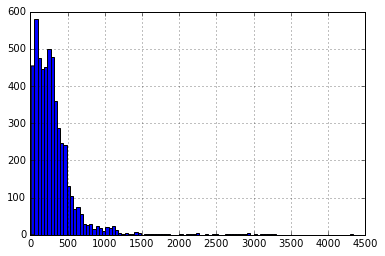

In [5]:
# Plot a histogram of alignment lengths for the BLAST data
data_fwd.alignment_length.hist(bins=100)

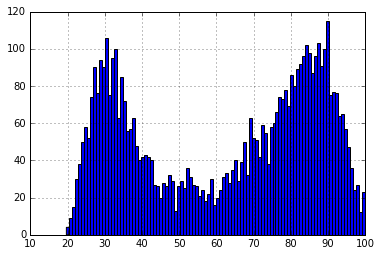

In [6]:
# Plot a histogram of percentage identity for the BLAST data
data_fwd.identity.hist(bins=100)

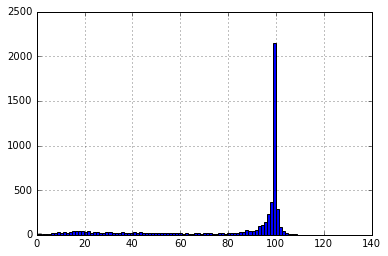

In [7]:
# Plot a histogram of query_coverage for the BLAST data
data_fwd.query_coverage.hist(bins=100)

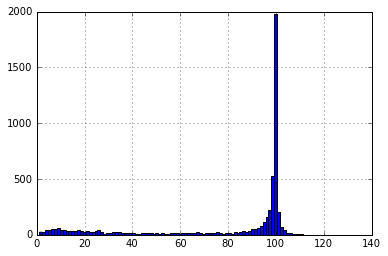

In [8]:
# Plot a histogram of percentage coverage for the BLAST data
data_fwd.subject_coverage.hist(bins=100)

<div class="alert alert-warning">
<b>QUESTIONS:</b>
<ul>
<li><b>What size are most one-way best `BLAST` alignments?</b>
<li><b>What is the typical query coverage?</b>
<li><b>What is the typical subject coverage?</b>
<li><b>What is the typical best `BLAST` match identity?</b>
</ul>
</div>

We can view the relationship between query coverage and subject coverage, and query coverage and match identity for these one-way best `BLAST` hits by plotting a 2D histogram, with the helper function `ex02.plot_hist2d()` in the cell below.

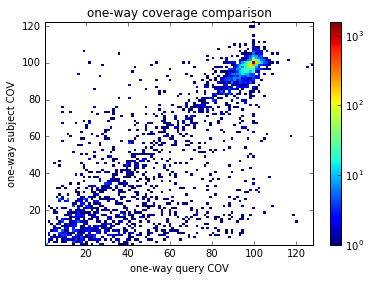

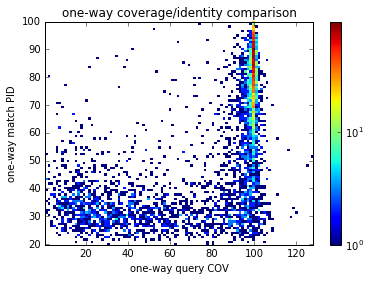

In [9]:
# Plot 2D histogram of subject sequence (match) coverage against query
# sequence coverag
rbbh.plot_hist2d(data_fwd.query_coverage, data_fwd.subject_coverage,
                "one-way query COV", "one-way subject COV", 
                "one-way coverage comparison")
rbbh.plot_hist2d(data_fwd.query_coverage, data_fwd.identity,
                "one-way query COV", "one-way match PID", 
                "one-way coverage/identity comparison")

<div class="alert alert-warning">
<b>QUESTIONS:</b>
<ul>
<li>**What is the query/subject coverage for most one-way best `BLAST` matches?**
<li>**Why do some one-way `BLAST` matches not have the same coverage for query and subject?**
<li>**What is the typical query coverage of a high percentage identity match?**
<li>**What is the typical query coverage of a low percentage identity match?**
</ul>
</div>

<div class="alert alert-danger" role="alert">
<b>QUESTION:</b><br />
<b>Do one-way best `BLAST` matches always identify equivalent proteins (<i>orthologs</i>)?</b>
</div>

## Reciprocal (Two-Way) Best `BLAST` matches (RBBH)

To perform a reciprocal BLAST search between two sets of proteins `S1` and `S2` (say), we need to carry out the *forward* search of `S1` vs `S2`, and the *reverse* search `S2` vs `S1`.

Reciprocal best `BLAST` matches are those where the sequence `G(S1)` (a gene/CDS from sequence set `S1`) used as a query makes its best `BLAST` match to sequence `G(S2)` (a gene/CDS from sequence set `S2`), and when sequence `G(S2)` is used as a query it makes its best match to sequence `G(S1)` (see figure below).

![Schematic of RBBH](images/rbbh.png)

We carried out the forward search above, for *P. syringae* B728a (our sequence set `S1`) against *P. fluorescens* NCIMB 11764 (our sequence set `S2`), and now we will carry out the corresponding reverse search by executing the command below at the terminal:

```
blastp -query data/pseudomonas/GCF_000293885.2_ASM29388v3_protein.faa \
       -db data/pseudomonas_blastp/GCF_000988485.1_ASM98848v1_protein \
       -max_target_seqs 1 \
       -outfmt "6 qseqid sseqid qlen slen length nident pident qcovs evalue bitscore" \
       -out data/pseudomonas_blastp/NCIMB_11764_vs_B728a.tab
```

As before, this would few minutes to complete, so to save some time the comparison has already been made for you, with the result file being placed in `pseudomonas_blastp/NCIMB_11764_vs_B728a.tab`.

We'll load the results into a *dataframe* called `data_rev` using the helper function `ex02.read_data()` in the cell below.

In [10]:
# Load one-way BLAST results into a data frame called data_fwd
data_rev = rbbh.read_data("data/pseudomonas_blastp/NCIMB_11764_vs_B728a.tab")

<div class="alert alert-warning">
<b>NOTE:</b> You could inspect <b>data_rev</b> using the <b>.head()</b> and <b>.describe()</b> methods, just as you did for <b>data_fwd</b>
</div>

The `ex02` module provides a function called `find_rbbh()` which calculates reciprocal best BLAST hits from forward and reverse `BLAST` searches. The calculation can be performed by executing the cell below.

In [11]:
# Calculate RBBH for the two Pseudomonas datasets
# This returns three dataframes: df1 and df2 are the forward and reverse BLAST
# results (filtered, if any filters were used), and rbbh is the dataframe of
# reciprocal best BLAST hits
df1, df2, data_rbbh = rbbh.find_rbbh(data_fwd, data_rev)

We can inspect the dataframe of RBBH using the `.head()` and `.describe()` methods, by executing the cells below.

In [12]:
# Peek at the first few lines of the RBBH results
data_rbbh.head()

,query_id_x,subject_id_x,identity_x,identity_y,query_coverage_x,query_coverage_y,subject_coverage_x,subject_coverage_y,bitscore_x,bitscore_y,Evalue_x,Evalue_y
0,WP_002551314.1,WP_031319201.1,91.73,91.73,100.000000,100.000000,100.000000,100.000000,246.0,246.0,3.000000e-85,3.000000e-85
1,WP_002551326.1,WP_003213601.1,94.32,94.32,100.634921,100.000000,100.000000,100.634921,625.0,625.0,0.000000e+00,0.000000e+00
2,WP_002551363.1,WP_017341421.1,75.81,75.81,94.416244,96.373057,96.373057,94.416244,244.0,258.0,2.000000e-82,8.000000e-88
3,WP_002551394.1,WP_017335870.1,96.36,96.36,94.827586,94.827586,94.827586,94.827586,511.0,511.0,0.000000e+00,0.000000e+00
4,WP_002551454.1,WP_003218037.1,94.42,94.42,100.000000,100.000000,100.000000,100.000000,380.0,380.0,1.000000e-135,9.000000e-136


In [13]:
# Show summary statistics for RBBH
data_rbbh.describe()

,identity_x,identity_y,query_coverage_x,query_coverage_y,subject_coverage_x,subject_coverage_y,bitscore_x,bitscore_y,Evalue_x,Evalue_y
count,3535.000000,3535.000000,3535.000000,3535.000000,3535.000000,3535.000000,3535.000000,3535.000000,3.535000e+03,3.535000e+03
mean,75.608518,75.605519,96.491999,96.427486,96.406108,96.517690,497.937115,498.246704,6.220469e-03,6.569461e-03
std,17.037202,17.026326,11.426042,12.091670,12.046244,11.500334,375.018657,375.116295,9.138723e-02,1.097458e-01
min,20.970000,20.970000,5.509182,3.730018,3.730018,5.509182,23.100000,23.100000,0.000000e+00,0.000000e+00
25%,68.180000,68.105000,98.058232,98.380098,98.378378,98.097243,240.500000,241.000000,0.000000e+00,0.000000e+00
50%,80.310000,80.300000,100.000000,100.000000,100.000000,99.919290,424.000000,426.000000,3.000000e-150,4.000000e-151
75%,87.980000,87.990000,100.000000,100.000000,100.000000,100.000000,654.000000,655.000000,1.000000e-80,5.500000e-81
max,100.000000,100.000000,128.000000,119.727891,120.560748,128.000000,6872.000000,6873.000000,2.400000e+00,3.500000e+00


It is inevitable that the RBBH set will have the same or fewer protein pairs in it, than the number of proteins in the smallest of the forward and reverse protein sets. But how many proteins have been filtered in this comparison? We can find out by executing the cell below.

In [14]:
# Report the size of each of the forward and reverse input, and rbbh output dataframes
s = '\n'.join(["Forward BLAST input: {0} proteins",
               "Reverse BLAST input: {1} proteins",
               "RBBH output: {2} proteins"])
print(s.format(len(data_fwd), len(data_rev), len(data_rbbh)))
print("(min difference = {0})".format(min(len(data_fwd), len(data_rev)) - len(data_rbbh)))

Forward BLAST input: 5256 proteins
Reverse BLAST input: 6371 proteins
RBBH output: 3535 proteins
(min difference = 1721)


<div class="alert alert-warning">
<b>Approximately what proportion of best <b>BLAST</b> matches have been discarded?</b>
</div>

### Visualising RBBH output
We can get a better idea of what this processing has done by looking at a visual representation of the percentage identity and coverage of RBBH, compared to the (forward) one-way matches. We can do this by executing the cells below.

First, let's look at the percentage identity of best `BLAST` matches:

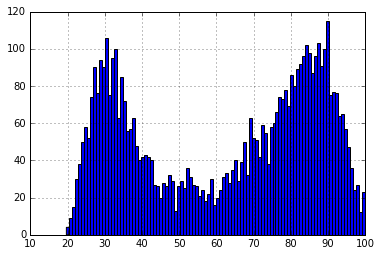

In [15]:
# Histogram of forward match percentage identity (one-way)
data_fwd.identity.hist(bins=100)

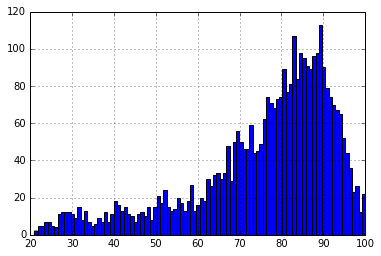

In [16]:
# Histogram of forward match percentage identity (RBBH)
data_rbbh.identity_x.hist(bins=100)

<div class="alert alert-warning">
<b>What has been the effect of excluding best matches that do not have an RBBH reverse match?</b>
</div>

Next, we can inspect the query and subject coverage of RBBH results, compared to the one-way forward `BLAST` matches by executing the cell below.

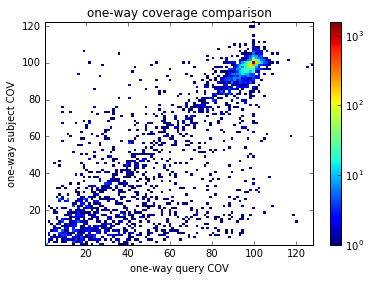

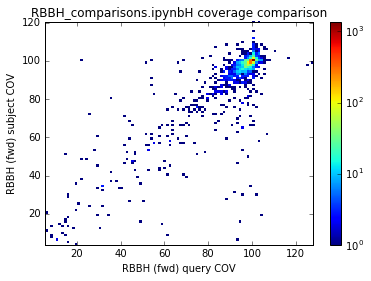

In [17]:
# Plot 2D histograms of query coverage against subject coverage for the 
# one-way forward matches, and those retained after calculating RBBH
rbbh.plot_hist2d(data_fwd.query_coverage, data_fwd.subject_coverage,
                      "one-way query COV", "one-way subject COV", 
                      "one-way coverage comparison")
rbbh.plot_hist2d(data_rbbh.query_coverage_x, data_rbbh.subject_coverage_x,
                      "RBBH (fwd) query COV", "RBBH (fwd) subject COV", 
                      "RBBH_comparisons.ipynbH coverage comparison")

<div class="alert alert-warning">
<ul>
<li><b>Which one-way matches have been excluded by carrying out RBBH?</b><br />
<li><b>What is the biological significance of excluding those matches?</b>
<li><b>What would be a reasonable filter to exclude the remaining suspect matches?</b>
</ul>
</div>

### Filtering RBBH output
The `find_rbbh()` function allows us to apply cutoff filters on percentage identity or coverage (or both) for an RBBH match - this, and visualisation of the results is done in the cells below.

<div class="alert alert-warning">
<b>NOTE:</b> There is a software tool (<a href="https://github.com/cboursnell/crb-blast"><b>CRB-BLAST</b></a> - Conditional Reciprocal Best BLAST) available that calculates reciprocal best matches, and statistically evaluates an 'optimal' E-value cutoff, in order to improve accuracy of ortholog assignment.
</div>

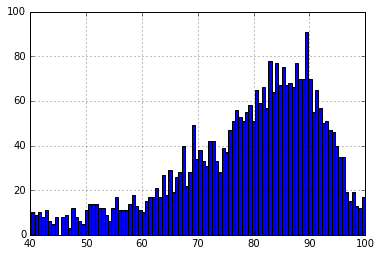

In [18]:
# Calculate ID and coverage-filtered RBBH for the two Pseudomonas datasets
# This returns three dataframes: df1_filtered and df2_filtered are the 
# filtered forward and reverse BLAST results , and rbbh_filtered is the
# dataframe of reciprocal best BLAST hits
df1_filtered, df2_filtered, rbbh_filtered = rbbh.find_rbbh(data_fwd, data_rev, pid=40, cov=70)

# Histogram of forward match percentage identity (RBBH, filtered)
rbbh_filtered.identity_x.hist(bins=100)

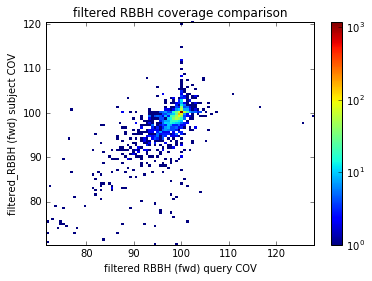

In [19]:
# Plot 2D histograms of query coverage against subject coverage for the 
# one-way forward matches retained after calculating RBBH and
# filtering on percentage identity and coverage
rbbh.plot_hist2d(rbbh_filtered.query_coverage_x, rbbh_filtered.subject_coverage_x,
                "filtered RBBH (fwd) query COV", "filtered_RBBH (fwd) subject COV", 
                "filtered RBBH coverage comparison")

### Visualising RBBH with `ACT`

Finally for this exercise, we will visualise the RBBH between *P. syringae* B728a and *P. fluorescens* NCIMB 11764 using `ACT` (as in exercise 01), comparing the output to that obtained by a `BLASTN` comparison of the chromosomes.

First, we need to generate an output file describing our (filtered) RBBH that `ACT` can read. We do this by executing the cell below. This does two things:

* Gets the locations of protein features on the chromosome of each organism from a `.gbff` file, using the helper function `read_genbank()`, putting them in a variable called `features`.
* Writes the RBBH to a `.crunch` format file (`pseudomonas_blastp/B728a_rbbh_NCIMB_11764.crunch`), which `ACT` can read.


In [20]:
# Read feature locations for each Pseudomonas file
features = rbbh.read_genbank("data/pseudomonas/GCF_000988485.1_ASM98848v1_genomic.gbff",
                             "data/pseudomonas/GCF_000293885.2_ASM29388v3_genomic.gbff")

# Write a .crunch file of filtered RBBH for the Pseudomonas comparisons
rbbh.write_crunch(rbbh_filtered, features,
                  fwd="GCF_000988485.1_ASM98848v1_genomic",
                  rev="GCF_000293885.2_ASM29388v3_genomic",
                  outdir="data/pseudomonas_blastp",
                  filename="B728a_rbbh_NCIMB_11764.crunch")

Loaded 11197 features
Wrote file to data/pseudomonas_blastp/B728a_rbbh_NCIMB_11764.crunch


Now we can load the two genome sequences, a `BLASTN` comparison, and the RBBH comparisons into `ACT`.

If `ACT` is not already running, we start it at the terminal with:

```
act &
```

and open the file dialog, expanding it to show five fields, as in the previous exercise. First, select `File -> Open` to bring up the file selection dialog box.

![Empty ACT file selection dialog, 3 fields](images/act1.png)

Then click on the `more files...` button once, to give us two more fields.

![Empty ACT file selection dialog, 5 fields](images/act2.png)

Now we add the sequence files, placing the *P. syringae* B728a genome sequence (`data/pseudomonas/GCF_000988485.1_ASM98848v1_genomic.fna`) in `Sequence file 2`, and the *P. fluorescens* NCIMB 11764 genome (`data/pseudomonas/GCF_000293885.2_ASM29388v3_genomic.fna`) in two slots: `Sequence file 1` and `Sequence file 3`, as shown.

![](images/act6.png)

Next, we add the RBBH output file `data/pseudomonas_blastp/B728a_rbbh_NCIMB_11764.crunch` to the field `Comparison file 1`:

![](images/act7.png)

And finally, we use a `BLASTN` comparison file (`data/pseudomonas_blastn/B728a_blastn_NCIMB_11764.tab`) comparing these two genomes, adding it to the field `Comparison file 2`:

![](images/act8.png)

and then click on the `Apply` button. This produces the initial alignment:

![](images/act9.png)

which we can zoom in on to inspect differences between the `BLASTN` and `BLASTP` comparisons.

![](images/act10.png)

<div class="alert alert-warning">
<ul>
<li><b>How do the BLASTN and RBBH alignments compare to each other, in general?</b><br />
<li><b>What kinds of differences are there?</b>
<li><b>What sorts of biologically useful information can you get from each alignment that is not available from the other alignment?</b>
<li><b>When is RBBH an appropriate comparison, and when is whole-genome alignment an appropriate comparison?</b>
</ul>
</div>